In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

import math

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
from datetime import timedelta


In [2]:
df_to_forecasting = pd.read_csv(r'../data/updated_data_ind/btc_ind.csv')

In [3]:
df_btc = pd.read_csv(r'../data/cryptoInd/btc_ind.csv')
close = df_btc['close']
df_btc.drop('close', axis = 1, inplace = True)
df_btc['close'] = close

close = df_to_forecasting['close']
df_to_forecasting.drop('close', axis = 1, inplace = True)
df_to_forecasting['close'] = close

In [4]:
df_btc.head(10)

Date    adj_close          low         high         open      volume  \
0  2017-11-09  7143.580078  7101.520020  7446.830078  7446.830078  3226249984   
1  2017-11-10  6618.140137  6436.870117  7312.000000  7173.729980  5208249856   
2  2017-11-11  6357.600098  6204.220215  6873.149902  6618.609863  4908680192   
3  2017-11-12  5950.069824  5519.009766  6625.049805  6295.450195  8957349888   
4  2017-11-13  6559.490234  5844.290039  6811.189941  5938.250000  6263249920   
5  2017-11-14  6635.750000  6461.750000  6764.979980  6561.479980  3197110016   
6  2017-11-15  7315.540039  6634.759766  7342.250000  6634.759766  4200880128   
7  2017-11-16  7871.689941  7176.580078  7967.379883  7323.240234  5123809792   
8  2017-11-17  7708.990234  7561.089844  8004.589844  7853.569824  4651670016   
9  2017-11-18  7790.149902  7463.439941  7884.990234  7697.209961  3667190016   

         SMA30        CMA30        EMA30        adx  ...        macd  \
0  6720.195964  3512.925750  6798.973215  37.428836  ...  547.298541   
1  6767.749967  3528.529843  6776.369081  36.238327  ...  482.149797   
2  6806.196647  3542.675194  6724.022958  34.548678  ...  404.828928   
3  6819.328646  3554.652282  6627.278816  32.896776  ...  307.126927   
4  6846.371322  3569.527717  6618.805243  30.978526  ...  275.694487   
5  6880.052669  3584.632260  6620.923338  29.188159  ...  254.009514   
6  6936.528678  3602.921024  6707.750426  28.041959  ...  288.353433   
7  7010.154004  3623.744287  6853.242865  27.865482  ...  356.340217   
8  7052.186686  3643.575578  6960.211286  27.748602  ...  392.566465   
9  7091.012695  3663.607338  7063.953613  27.418156  ...  422.949436   

   macdsignal    macdhist        rsi       stdev      slowk      slowd  \
0  521.810007   25.488533  65.836438  604.852006  33.184032  38.772059   
1  513.877965  -31.728169  55.203606  565.647850  30.022892  33.577955   
2  492.068158  -87.239230  50.841321  514.557416  13.668599  25.625174   
3  455.079912 -147.952985  44.895667  489.412741  14.127749  19.273080   
4  419.202827 -143.508340  53.591323  462.353197  27.607649  18.467999   
5  386.164164 -132.154650  54.552858  425.947799  45.116957  28.950785   
6  366.602018  -78.248585  62.060446  423.778328  71.596855  48.107154   
7  364.549658   -8.209441  66.859284  480.166804  85.636797  67.450203   
8  370.153019   22.413446  64.309648  510.920874  93.647816  83.627156   
9  380.712303   42.237134  65.022537  542.425229  89.503126  89.595913   

   dollar_close  sp500_close        close  
0     94.351997  2584.620117  7143.580078  
1     94.278000  2582.300049  6618.140137  
2     94.278000  2582.300049  6357.600098  
3     94.278000  2582.300049  5950.069824  
4     94.388000  2584.840088  6559.490234  
5     93.723000  2578.870117  6635.750000  
6     93.725998  2564.620117  7315.540039  
7     93.853996  2585.639893  7871.689941  
8     93.574997  2578.850098  7708.990234  
9     93.574997  2578.850098  7790.149902  

[10 rows x 23 columns]

In [5]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_btc['Date'], y=df_btc['close'], name='BITCOIN', mode='lines',line=dict(color='red')))
fig2.show()

In [6]:
inicial_date = '2021-01-01'
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_to_forecasting['Date'] = pd.to_datetime(df_to_forecasting['Date'])
inicial_date = pd.to_datetime(inicial_date)
df_btc = df_btc[df_btc['Date'] >= inicial_date]
df_to_forecasting = df_to_forecasting[df_to_forecasting['Date'] >= inicial_date]

# Scaling

In [7]:
df_btc.set_index('Date', inplace=True)
scaled_df = df_btc.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_btc)
scaled_df = pd.DataFrame(scaled_feat, index = df_btc.index, columns=df_btc.columns)
scaled_df.head()

adj_close       low      high      open    volume     SMA30  \
Date                                                                      
2021-01-01   0.000000  0.002146  0.000000  0.000000  0.080045  0.000000   
2021-01-02   0.072085  0.009783  0.090701  0.009919  0.160510  0.015670   
2021-01-03   0.089228  0.088413  0.127789  0.081321  0.192535  0.031205   
2021-01-04   0.068017  0.000000  0.097976  0.098998  0.199943  0.046012   
2021-01-05   0.120920  0.039789  0.123427  0.077369  0.159566  0.065516   

               CMA30     EMA30       adx    bb_low  ...      macd  macdsignal  \
Date                                                ...                         
2021-01-01  0.000000  0.000000  0.901052  0.011360  ...  0.733716    0.728282   
2021-01-02  0.001791  0.020825  0.944293  0.004612  ...  0.759492    0.744059   
2021-01-03  0.003629  0.041200  0.987944  0.000000  ...  0.781665    0.761794   
2021-01-04  0.005403  0.056365  0.968566  0.007928  ...  0.789449    0.777777   
2021-01-05  0.007325  0.076275  0.956090  0.018551  ...  0.807734    0.794780   

            macdhist       rsi     stdev     slowk     slowd  dollar_close  \
Date                                                                         
2021-01-01  0.711648  0.892475  0.241080  0.958295  0.949689      0.039240   
2021-01-02  0.753280  0.951151  0.305832  0.914876  0.969087      0.039240   
2021-01-03  0.776665  0.961927  0.363909  0.850969  0.947428      0.039240   
2021-01-04  0.755741  0.872944  0.382972  0.726270  0.865187      0.035275   
2021-01-05  0.767926  0.915171  0.407550  0.740109  0.803240      0.000000   

            sp500_close     close  
Date                               
2021-01-01     0.050570  0.000000  
2021-01-02     0.050570  0.072085  
2021-01-03     0.050570  0.089228  
2021-01-04     0.000000  0.068017  
2021-01-05     0.023916  0.120920  

[5 rows x 22 columns]

# Correlation Matrix

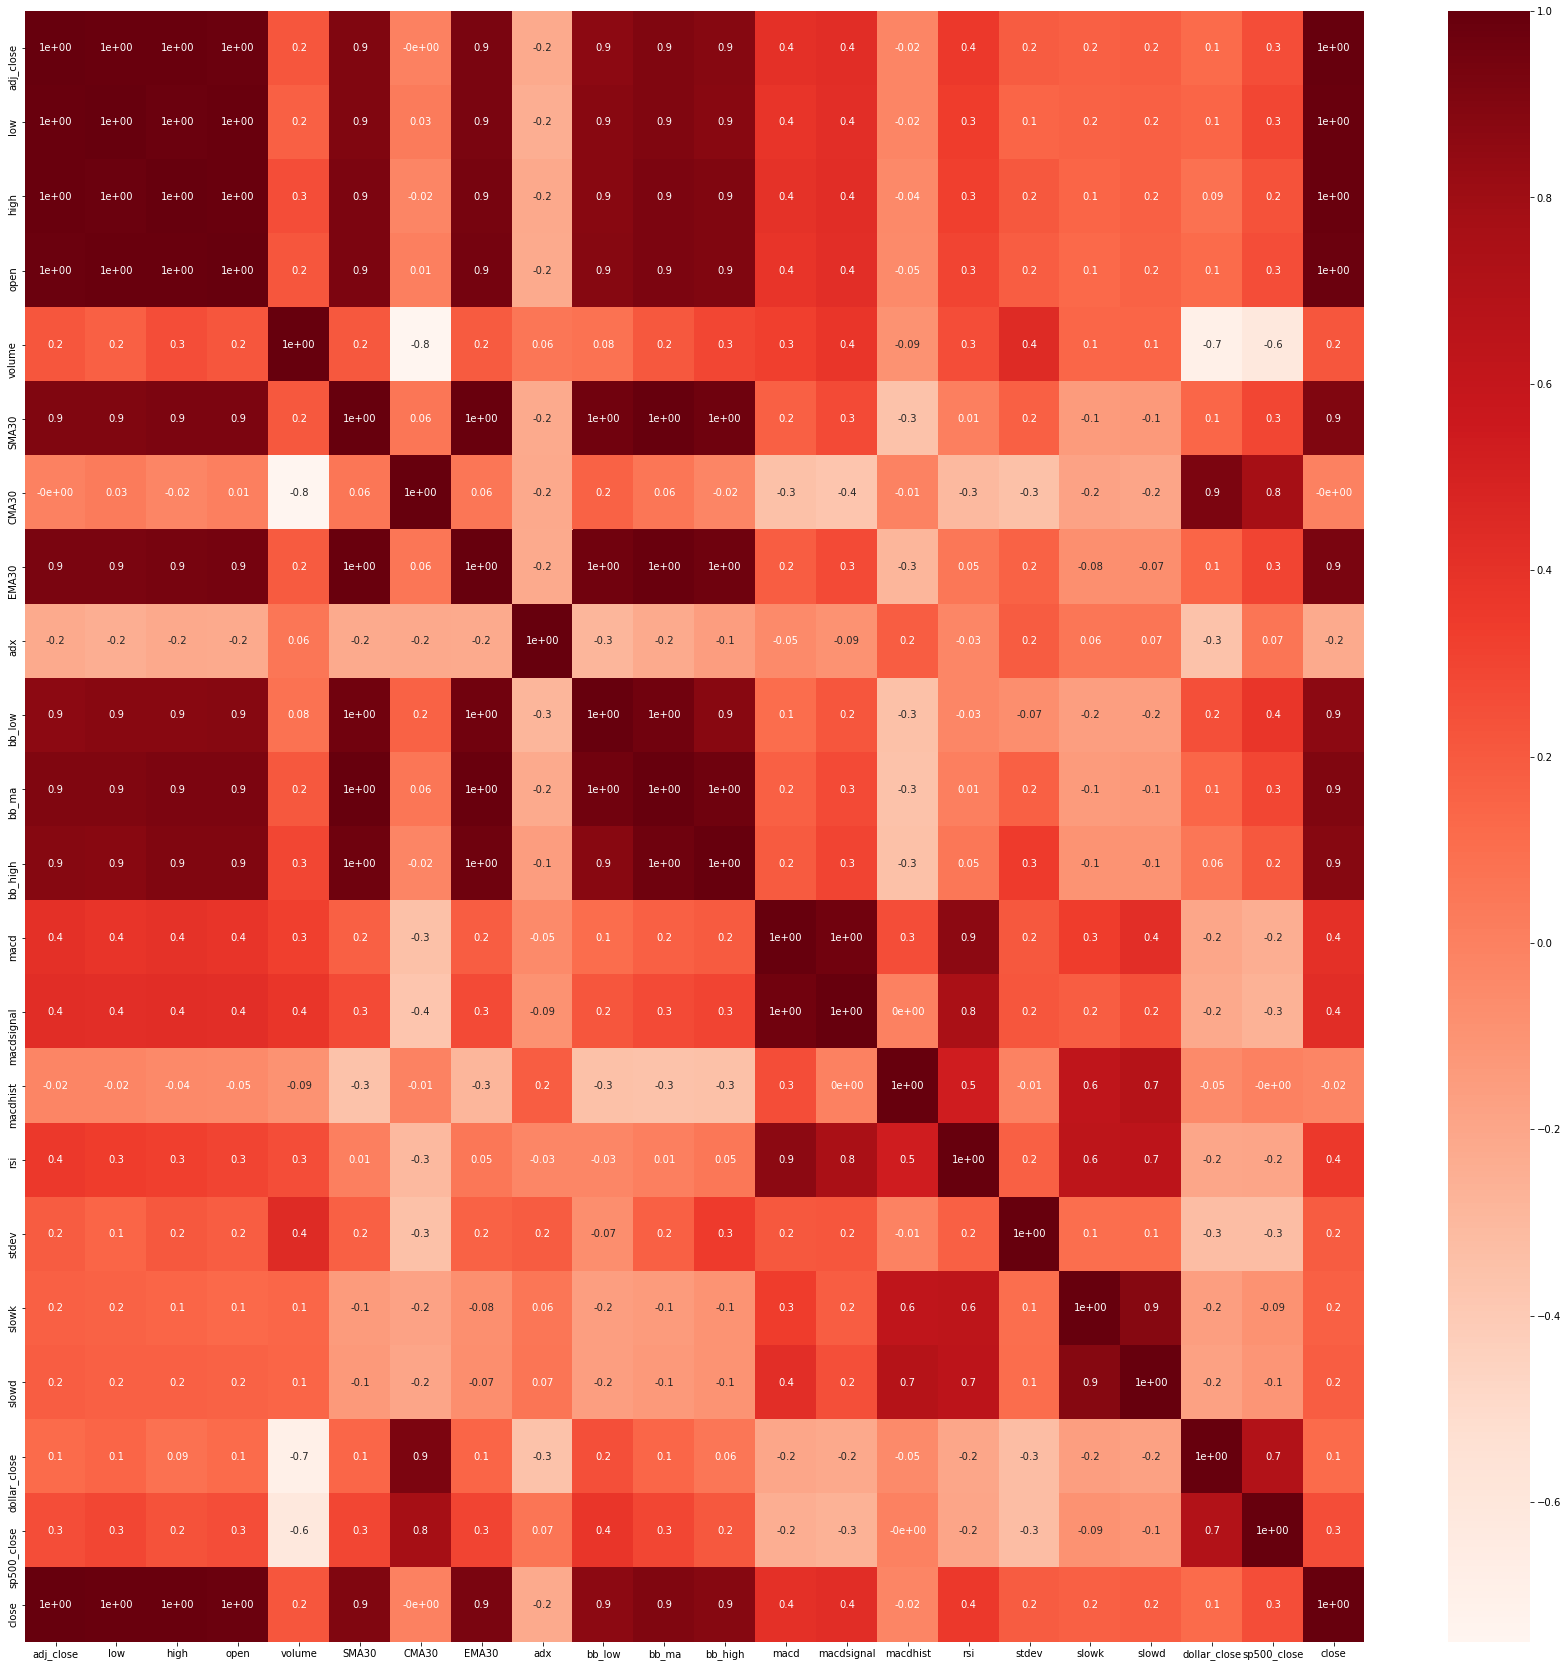

In [8]:
#Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

In [9]:
scaled_df.columns

Index(['adj_close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30', 'EMA30',
       'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal', 'macdhist',
       'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close', 'sp500_close',
       'close'],
      dtype='object')

In [10]:
df_btc.drop(['low', 'high', 'open','SMA30','EMA30','bb_low',
 'bb_ma', 'bb_high', 'stdev', 'sp500_close'], axis=1, inplace=True)

df_to_forecasting.drop(['low', 'high', 'open','SMA30','EMA30','bb_low',
 'bb_ma', 'bb_high', 'stdev', 'sp500_close'], axis=1, inplace=True)

## TimeBaseCV

In [11]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

# Models

## Function to Apply the Models

In [12]:
def add_days(df, forecast_length):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=range(2))
    df1.columns = ['close', 'Date']
    df = df.append(df1)
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'Date']
    x = pd.to_datetime(x, format='%Y-%m-%d')
    for i in range(forecast_length):
        df.at[df.index[end_point + i], 'Date'] = x + timedelta(days=1+i)
        df.at[df.index[end_point + i], 'close'] = 0
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.drop(['Date'], axis=1)
    return df

In [13]:
def forecasting(model,df1, forecast_length):
    df3 = df1[['close', 'Date']]
    df3 = add_days(df3, forecast_length)
    finaldf = df1.drop('Date', axis=1)
    finaldf = finaldf.reset_index(drop=True)
    end_point = len(finaldf)
    x = end_point - forecast_length
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'close']
    finaldf_train_y = finaldf_train['close']

    fit = model.fit(finaldf_train_x, finaldf_train_y)
    yhat = []
    end_point = len(finaldf)
    df3_end = len(df3)
    for i in range(forecast_length, 0, -1):
        y = end_point - i
        inputfile = finaldf.loc[y:end_point, :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'close']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df3.at[df3.index[df3_end - i], 'close'] = pred[0]
        finaldf = df1.drop('Date', axis=1)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred)
    yhat = np.array(yhat)
    return yhat

In [16]:
def show_results(df_results, df,objetive ='close',train_period_split=100,test_period_split=5, *args):
    #Scalling
    scaler = MinMaxScaler()
    scaled_feat = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_feat, index = df.index, columns=df.columns)

    X_scaled = scaled_df.drop(objetive, axis=1)
    y_scaled = scaled_df[objetive]

    X_tbcv = X_scaled.reset_index()
    y_scaled = y_scaled.reset_index()
    y_scaled['Date'] = pd.to_datetime(y_scaled['Date'], format='%Y-%m-%d')   
    X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
    tscv = TimeBasedCV(train_period=train_period_split,
        test_period=test_period_split,
        freq='days')
    colours =['red', 'blue', 'yellow', 'pink']
    fig2 = go.Figure()
    count = 0
    for idx,arg in enumerate(args):
        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
            X_train = X_tbcv.loc[train_index]
            y_train = y_scaled.loc[train_index]
            X_train['close'] = y_train['close']
            y_test  = y_scaled.loc[test_index]
            X_test = X_tbcv.loc[test_index]
            X_test.set_index('Date', inplace=True)
            y_test.set_index('Date', inplace=True)
            mae_list = []
            mse_list = []
            r2_list = []
            rmse_list = []
            y_pred_test = forecasting(model=arg,df1=X_train,forecast_length=test_period_split)
            # prints metric results         
            value_mae = mean_absolute_error(y_test, y_pred_test)
            value_mse = mean_squared_error(y_test, y_pred_test)
            value_r2 = r2_score(y_test, y_pred_test)
            value_rmse = math.sqrt(value_mse)
            #print(value_mae, value_mse, value_r2)
            # append the accuracies, the time and the number of iterations in the corresponding list
            mae_list.append(value_mae)
            mse_list.append(value_mse)
            r2_list.append(value_r2)
            rmse_list.append(value_rmse)

            real_name = 'real '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to "\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            pred_name = 'pred '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to"\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            X_train['close'] = y_train
            X_pred_test = X_test.copy()
            X_test['close'] = y_test
            X_pred_test['close'] = y_pred_test

            X_pred_test_undo = scaler.inverse_transform(X_pred_test)
            X_test_undo = scaler.inverse_transform(X_test)

            X_pred_test_graphic = pd.DataFrame(data = X_pred_test_undo, index = X_pred_test.index, columns=X_pred_test.columns)
            X_test_graphic = pd.DataFrame(data =X_test_undo, index = X_test.index, columns=X_test.columns)

            fig2.add_trace(go.Scatter(x=X_test_graphic.index, y=X_test_graphic['close'], name=real_name, mode='lines',line=dict(color='green')))
            fig2.add_trace(go.Scatter(x=X_pred_test_graphic.index, y=X_pred_test_graphic['close'], name=pred_name, mode='lines', line=dict(color=colours[idx])))

        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))
        mae = round(np.mean(mae_list),10)
        mse = round(np.mean(mse_list),10)
        r2 = round(np.mean(r2_list),10)
        rmse = round(np.mean(rmse_list),10)
        df_results.iloc[count] = mae, mse,rmse, r2
        count+=1
    fig2.show()
    return df_results
        
    

## Random Forest

In [17]:
rf_se = RandomForestRegressor(random_state=10,criterion='mse')
rf_ae = RandomForestRegressor(random_state=10,criterion='mae')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mse','mae'])
show_results(df, df_btc,'close',100,5, rf_se, rf_ae)

MAE       MSE      RMSE        R2
mse  0.022264  0.000732   0.02705  -1.50122
mae  0.021531  0.000726  0.026952 -1.483022

In [18]:
rf_5 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20)
rf_50 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['5','20', '50'])
show_results(df, df_btc,'close',100,5,rf_5, rf_20,rf_50)

MAE       MSE      RMSE        R2
5   0.021859  0.000743   0.02726 -1.540136
20  0.021531  0.000726  0.026952 -1.483022
50  0.021531  0.000726  0.026952 -1.483022

In [19]:
rf_auto = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto')
rf_sqrt = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='sqrt')
rf_log2 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20,max_features='log2' )
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_btc,'close',100,5,rf_auto, rf_sqrt,rf_log2)

MAE       MSE      RMSE        R2
auto  0.021531  0.000726  0.026952 -1.483022
sqrt   0.02818   0.00115  0.033916 -2.932095
log2   0.02818   0.00115  0.033916 -2.932095

In [21]:
rf_10 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto', n_estimators=10)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto',n_estimators=30)
rf_30 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20,max_features='auto', n_estimators=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['10','30', '50'])
show_results(df, df_btc,'close',100,5,rf_10, rf_20,rf_30)

MAE       MSE      RMSE        R2
10  0.022285  0.000801  0.028311 -1.739738
30  0.020954  0.000685  0.026168 -1.340674
50  0.020914    0.0007  0.026464  -1.39392

In [23]:
rf_final = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto', n_estimators=30)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_btc,'close',100,5, rf_final)

MAE       MSE      RMSE        R2
final  0.020954  0.000685  0.026168 -1.340674

## Gradient Boost

In [24]:
gb_mae = GradientBoostingRegressor(random_state = 10 , criterion='mae')
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='mse')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mae','mse'])
show_results(df, df_btc,'close',100,5,gb_mae, gb_mse)

MAE       MSE      RMSE        R2
mae  0.021225  0.000568  0.023838 -0.942446
mse  0.021047  0.000563  0.023734 -0.925521

In [25]:
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50)
gb_100 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 100)
gb_150 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 150)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['50','100', '150'])
show_results(df, df_btc,'close',100,5,gb_50, gb_100, gb_150)

MAE       MSE      RMSE        R2
50   0.021017   0.00056  0.023671 -0.915392
100  0.021047  0.000563  0.023734 -0.925521
150  0.021053  0.000563  0.023738 -0.926136

In [26]:
gb_auto = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features=  'auto' )
gb_sqrt = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features = 'sqrt')
gb_log2 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_btc,'close',100,5,gb_auto, gb_sqrt, gb_log2)

MAE       MSE      RMSE        R2
auto  0.021017   0.00056  0.023671 -0.915392
sqrt  0.032693  0.001543   0.03928 -4.274269
log2  0.032693  0.001543   0.03928 -4.274269

In [27]:
gb_final = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features=  'auto')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['final'])
show_results(df, df_btc,'close',100,5,gb_final)

MAE      MSE      RMSE        R2
final  0.021017  0.00056  0.023671 -0.915392

## Neural Nerworks

In [29]:
nn_2525 = MLPRegressor(hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_10101010 = MLPRegressor(hidden_layer_sizes=(20), random_state=15,max_iter = 3000)
nn_10 = MLPRegressor(hidden_layer_sizes=(30), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['10','20', '30'])
show_results(df, df_btc,'close',100,5,nn_2525, nn_10101010, nn_10)

MAE       MSE      RMSE         R2
10  0.010829  0.000208  0.014422   0.288989
20   0.08204  0.007193  0.084811 -23.587595
30  0.141225  0.020598  0.143521 -69.410654

In [30]:
nn_identity = MLPRegressor(activation = 'identity',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_logistic = MLPRegressor(activation = 'logistic',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_tanh = MLPRegressor(activation = 'tanh',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_relu = MLPRegressor(activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['identity','logistic', 'tanh', 'relu'])
show_results(df, df_btc,'close',100,5,nn_identity, nn_logistic, nn_tanh, nn_relu)

MAE       MSE      RMSE         R2
identity  0.159912  0.026763  0.163595 -90.484851
logistic  0.016479  0.000445    0.0211  -0.521842
tanh      0.120609  0.014937  0.122219  -50.06045
relu      0.010829  0.000208  0.014422   0.288989

In [31]:
nn_lbfgs = MLPRegressor(solver = 'lbfgs', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_sgd = MLPRegressor(solver = 'sgd', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_adam = MLPRegressor(solver = 'adam', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['lbfgs','sgd', 'adam'])
show_results(df, df_btc,'close',100,5,nn_lbfgs, nn_sgd, nn_adam)

MAE       MSE      RMSE        R2
lbfgs  0.019578  0.000434  0.020835 -0.483902
sgd    0.014782  0.000351  0.018726 -0.198665
adam   0.010829  0.000208  0.014422  0.288989

In [32]:
nn_constant = MLPRegressor(learning_rate = 'constant',solver = 'adam', activation = 'relu',
hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_invscaling = MLPRegressor(learning_rate = 'invscaling',solver = 'adam', activation = 'relu',
hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_adaptive = MLPRegressor(learning_rate = 'adaptive',solver = 'adam', activation = 'relu',
hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['constant','invscaling', 'nn_adaptive'])
show_results(df, df_btc,'close',100,5,nn_constant, nn_invscaling, nn_adam)

MAE       MSE      RMSE        R2
constant     0.010829  0.000208  0.014422  0.288989
invscaling   0.010829  0.000208  0.014422  0.288989
nn_adaptive  0.010829  0.000208  0.014422  0.288989

In [33]:
nn_final = MLPRegressor(learning_rate = 'adaptive',solver = 'adam', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['final'])
show_results(df, df_btc,'close',100,5,nn_final)

MAE       MSE      RMSE        R2
final  0.010829  0.000208  0.014422  0.288989

## XGBoost

In [34]:
xgb_mae = XGBRegressor(random_state = 10 , criterion='absolute_error')
xgb_mse = XGBRegressor(random_state = 10 , criterion='squared_error')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['mae','mse'])
show_results(df, df_btc,'close',100,5,xgb_mae, xgb_mse)

[16:48:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.

MAE       MSE      RMSE        R2
mae  0.02662  0.000853  0.029204 -1.915362
mse  0.02662  0.000853  0.029204 -1.915362

In [35]:
xgb_gbtree = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130)
xgb_gblinear = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130)
xgb_dart = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['gbtree','gblinear','dart'])

show_results(df, df_btc,'close',100,5,xgb_gbtree, xgb_gblinear,xgb_dart )

MAE       MSE      RMSE        R2
gbtree     0.02662  0.000853  0.029204 -1.915362
gblinear  0.035148  0.001689  0.041102 -4.774813
dart       0.02662  0.000853  0.029204 -1.915362

In [36]:
xgb_true = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130, validate_parameters = True)
xgb_false = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130, validate_parameters = False)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])

show_results(df, df_btc,'close',100,5,xgb_true, xgb_false)

MAE       MSE      RMSE        R2
True   0.02662  0.000853  0.029204 -1.915362
False  0.02662  0.000853  0.029204 -1.915362

In [37]:
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False)
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_btc,'close',100,5,xgb_true, xgb_false)

MAE       MSE      RMSE        R2
True    0.03238  0.001547  0.039333 -4.288352
False  0.035967  0.001761   0.04196 -5.018455

In [38]:
xgb_005 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.05)
xgb_01 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.1)
xgb_03 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.3)
xgb_05 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.5)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['0,05', '0,1', '0,3', '0,5'])
show_results(df, df_btc,'close',100,5, xgb_005,xgb_01, xgb_03, xgb_05 )

MAE       MSE      RMSE        R2
0,05  0.036287  0.001771  0.042078 -5.052313
0,1   0.037802  0.001897  0.043555 -5.484617
0,3    0.03203   0.00147  0.038343 -4.025403
0,5    0.03668  0.001808  0.042515 -5.178744

In [39]:
xgb_final = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_btc,'close',100,5, xgb_final)

MAE       MSE      RMSE        R2
final  0.03537  0.001724  0.041517 -4.892098

# Results

In [41]:
df_to_forecasting.tail()

Date     adj_close       volume         CMA30        adx  \
1637 2022-05-04  39698.371094  36754404490  18266.265660  25.002078   
1638 2022-05-05  36575.140625  43106256317  18276.308927  25.325236   
1639 2022-05-06  36040.921875  37795577489  18286.048298  25.803019   
1640 2022-05-07  35501.953125  24375896406  18295.481670  26.497102   
1641 2022-05-08  34226.796875  36945944576  18304.206377  27.573447   

             macd   macdsignal    macdhist        rsi      slowk      slowd  \
1637  -930.012529  -960.938047   30.925519  48.157255  44.497249  30.817732   
1638 -1060.741958  -980.898830  -79.843129  38.528920  38.697585  36.090936   
1639 -1193.692814 -1023.457627 -170.235188  37.167079  40.523743  41.239525   
1640 -1327.247911 -1084.215684 -243.032228  35.799283  13.902552  31.041293   
1641 -1518.481629 -1171.068873 -347.412757  32.744603   9.723924  21.383406   

      dollar_close         close  
1637    102.594002  39698.371094  
1638    103.802002  36575.140625  
1639    103.694000  36040.921875  
1640    103.694000  35501.953125  
1641    103.694000  34226.796875

In [40]:
forecasting(nn_final,df_to_forecasting,1)

array([[28726.68270074]])

In [42]:
forecasting(gb_final,df_to_forecasting,1)

array([[34335.96610711]])